# Word2Vec (Skipgram )

### Importing Library

In [132]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [133]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import json 
import time
import string

In [134]:
np.__version__, torch.__version__

('1.25.2', '2.1.1+cpu')

In [135]:
matplotlib.__version__

'3.7.2'

## 1. Load data and download resources

In [136]:
import nltk
# Download NLTK resources: 'reuters' corpus for text classification and 'punkt' tokenizer model for sentence splitting.

nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [137]:
# Assigning NLTK's Reuters corpus sentences to 'corpus_reuters' for further processing.
from nltk.corpus import reuters

corpus_reuters = reuters.sents()

In [138]:
# Joining each sentence in 'corpus_reuters' into a single string and tokenizing it into words, converting them to lowercase.
corpus_reuters = [" ".join(sent) for sent in corpus_reuters]
corpus_reuters = [nltk.word_tokenize(sent.lower()) for sent in corpus_reuters]

In [139]:
# Defining a lambda function 'flatten' to flatten a list of lists.
flatten = lambda l: [item for sublist in l for item in sublist]

# Calculating the total number of tokens in the 'corpus_reuters' by summing the lengths of all sentences.
total_tokens = sum(len(sentence) for sentence in corpus_reuters)


In [140]:
# Printing the total number of passages and tokens in the corpus_reuters.
print("Total Passages in the corpus:", len(corpus_reuters))
print("Total Tokens in the corpus:", total_tokens)


Total Passages in the corpus: 54716
Total Tokens in the corpus: 1728932


In [141]:
# Subset of 1000 passages created for efficiency, testing, resource constraints, and concise example demonstration.
corpus_ss = corpus_reuters[:1000]

In [142]:
# Defining a lambda function 'flatten' to flatten a list of lists and creating a vocabulary list.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_ss)))  # 'corpus_ss' contains tokenized sentences

In [143]:
#append UNK
vocabs.append('<UNK>')

In [144]:
vocabs[:5]

['laboratories', 'hold', 'us', 'ponderosa', 'germany']

In [145]:
len(corpus_ss), len(vocabs)

(1000, 4153)

In [146]:
# Creating word to index and index to word dictionaries
word2index = {v: idx for idx, v in enumerate(vocabs)}
# Adding '<UNK>' token to word2index
word2index['<UNK>'] = len(vocabs) - 1

# Creating index to word dictionary
index2word = {v: k for k, v in word2index.items()}

# Calculating lengths of dictionaries
len(word2index), len(index2word)


(4153, 4153)

## 2. Build Co-occurence Matrix X

In [147]:
corpus = corpus_ss
from collections import Counter

X_i = Counter(flatten(corpus))
X_i

Counter({'asian': 2,
         'exporters': 5,
         'fear': 2,
         'damage': 7,
         'from': 126,
         'u': 140,
         '.': 1728,
         's': 337,
         '.-': 6,
         'japan': 63,
         'rift': 1,
         'mounting': 1,
         'trade': 69,
         'friction': 2,
         'between': 24,
         'the': 1197,
         'and': 461,
         'has': 110,
         'raised': 3,
         'fears': 1,
         'among': 9,
         'many': 6,
         'of': 721,
         'asia': 2,
         "'": 234,
         'exporting': 2,
         'nations': 3,
         'that': 125,
         'row': 1,
         'could': 24,
         'inflict': 1,
         'far': 7,
         '-': 259,
         'reaching': 3,
         'economic': 21,
         ',': 1380,
         'businessmen': 4,
         'officials': 22,
         'said': 465,
         'they': 74,
         'told': 23,
         'reuter': 4,
         'correspondents': 2,
         'in': 512,
         'capitals': 1,
         'a': 468

In [148]:
skip_grams = []

for doc in corpus:
    for i in range(1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        for each_out in outside:
            skip_grams.append((center, each_out))
skip_grams

[('exporters', 'asian'),
 ('exporters', 'fear'),
 ('fear', 'exporters'),
 ('fear', 'damage'),
 ('damage', 'fear'),
 ('damage', 'from'),
 ('from', 'damage'),
 ('from', 'u'),
 ('u', 'from'),
 ('u', '.'),
 ('.', 'u'),
 ('.', 's'),
 ('s', '.'),
 ('s', '.-'),
 ('.-', 's'),
 ('.-', 'japan'),
 ('japan', '.-'),
 ('japan', 'rift'),
 ('rift', 'japan'),
 ('rift', 'mounting'),
 ('mounting', 'rift'),
 ('mounting', 'trade'),
 ('trade', 'mounting'),
 ('trade', 'friction'),
 ('friction', 'trade'),
 ('friction', 'between'),
 ('between', 'friction'),
 ('between', 'the'),
 ('the', 'between'),
 ('the', 'u'),
 ('u', 'the'),
 ('u', '.'),
 ('.', 'u'),
 ('.', 's'),
 ('s', '.'),
 ('s', '.'),
 ('.', 's'),
 ('.', 'and'),
 ('and', '.'),
 ('and', 'japan'),
 ('japan', 'and'),
 ('japan', 'has'),
 ('has', 'japan'),
 ('has', 'raised'),
 ('raised', 'has'),
 ('raised', 'fears'),
 ('fears', 'raised'),
 ('fears', 'among'),
 ('among', 'fears'),
 ('among', 'many'),
 ('many', 'among'),
 ('many', 'of'),
 ('of', 'many'),
 ('of

In [149]:
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('exporters', 'asian'): 1,
         ('exporters', 'fear'): 1,
         ('fear', 'exporters'): 1,
         ('fear', 'damage'): 1,
         ('damage', 'fear'): 1,
         ('damage', 'from'): 1,
         ('from', 'damage'): 1,
         ('from', 'u'): 2,
         ('u', 'from'): 2,
         ('u', '.'): 133,
         ('.', 'u'): 140,
         ('.', 's'): 239,
         ('s', '.'): 257,
         ('s', '.-'): 6,
         ('.-', 's'): 6,
         ('.-', 'japan'): 1,
         ('japan', '.-'): 1,
         ('japan', 'rift'): 1,
         ('rift', 'japan'): 1,
         ('rift', 'mounting'): 1,
         ('mounting', 'rift'): 1,
         ('mounting', 'trade'): 1,
         ('trade', 'mounting'): 1,
         ('trade', 'friction'): 2,
         ('friction', 'trade'): 2,
         ('friction', 'between'): 1,
         ('between', 'friction'): 1,
         ('between', 'the'): 8,
         ('the', 'between'): 8,
         ('the', 'u'): 54,
         ('u', 'the'): 58,
         ('.', 'and'): 6,
         ('a

GloVe includes a weighting function to scale down too frequent words.

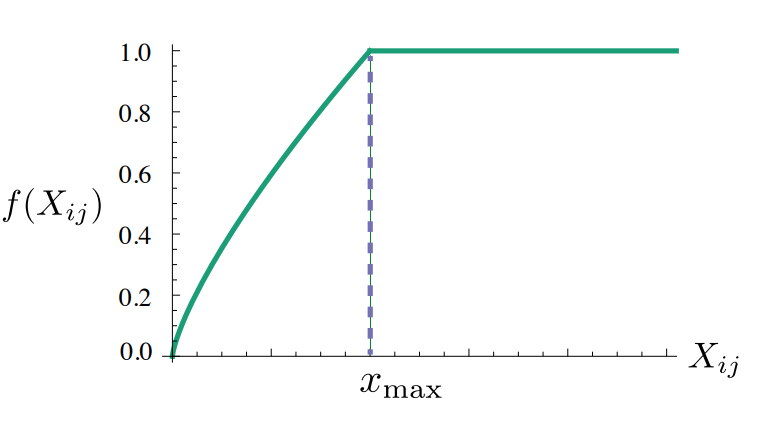

In [150]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [151]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

In [152]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

#### Testing the method

In [153]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [154]:
x

array([[ 886],
       [3051]])

In [155]:
y

array([[ 508],
       [3450]])

In [156]:
cooc

array([[2.39789527],
       [0.69314718]])

In [157]:
weighting

array([[0.1910049 ],
       [0.05318296]])

## 4. Model
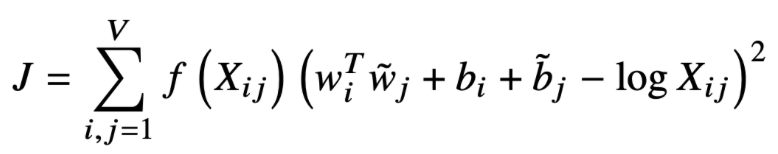

In [158]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [159]:
#test our system
voc_size = len(vocabs)
emb_size = 2
model = Glove(voc_size, emb_size)

In [160]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [161]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [162]:
loss

tensor(0.5976, grad_fn=<SumBackward0>)

## 4. Training

In [163]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [184]:
num_epochs = 10000
total_loss = 0.0  # Initialize total loss

total_start = time.time()  # Start time for total training time
# Training
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    
    end = time.time()
    
    epoch_mins, epoch_secs = divmod(end - start, 60)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss:.6f} | time: {epoch_mins:.0f}m {epoch_secs:.0f}s")

average_loss = total_loss / num_epochs

total_end = time.time()  # End time for total training time
total_mins, total_secs = divmod(total_end - total_start, 60)

print(f"Total training time: {total_mins:.0f}m {total_secs:.0f}s")
print(f"Average training loss: {average_loss:.6f}")

Epoch: 1000 | Loss: 0.620175 | time: 0m 0s
Epoch: 2000 | Loss: 0.751669 | time: 0m 0s
Epoch: 3000 | Loss: 2.419659 | time: 0m 0s
Epoch: 4000 | Loss: 3.208386 | time: 0m 0s
Epoch: 5000 | Loss: 2.218206 | time: 0m 0s
Epoch: 6000 | Loss: 1.589377 | time: 0m 0s
Epoch: 7000 | Loss: 2.670194 | time: 0m 0s
Epoch: 8000 | Loss: 1.244073 | time: 0m 0s
Epoch: 9000 | Loss: 0.974913 | time: 0m 0s
Epoch: 10000 | Loss: 0.313813 | time: 0m 0s
Total training time: 3m 12s
Average training loss: 1.391059


## 5. Plot the embeddings


In [165]:
vocabs[:10]

['laboratories',
 'hold',
 'us',
 'ponderosa',
 'germany',
 'gdyn',
 'nominal',
 'cra',
 'current',
 'ramadan']

In [166]:
word = vocabs[0]

In [167]:
id = word2index[word]
id

0

In [168]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [169]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[0.8197, 0.3589]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.4273, -0.1180]], grad_fn=<EmbeddingBackward0>))

In [170]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[0.1962, 0.1205]], grad_fn=<DivBackward0>)

In [171]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

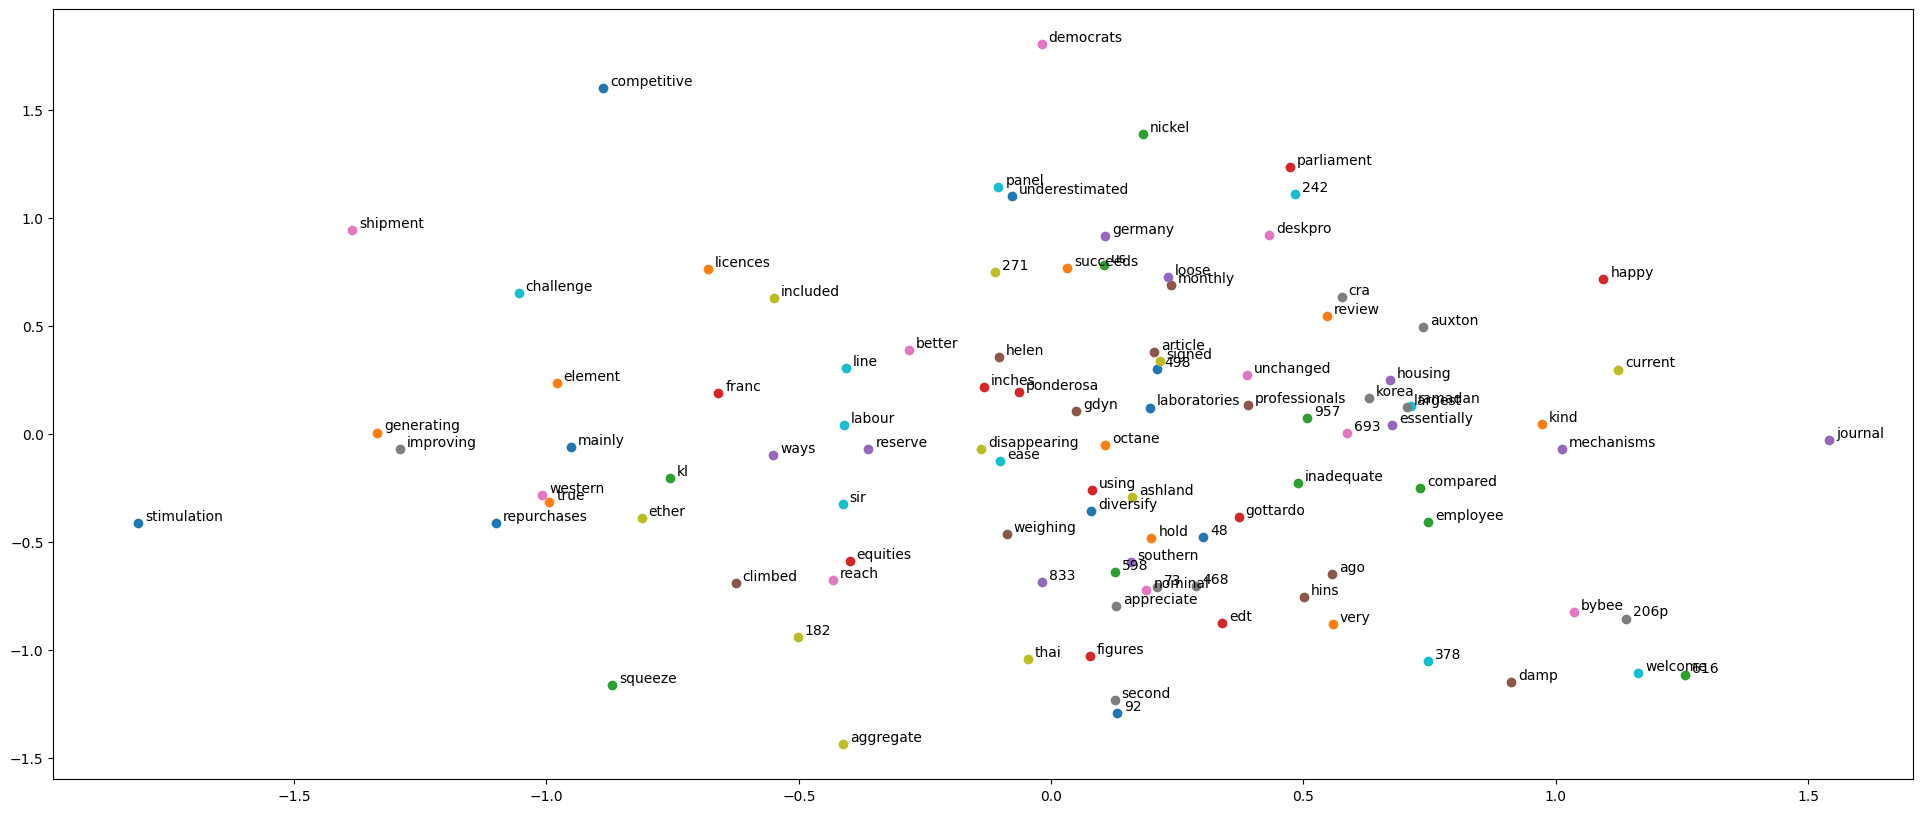

In [172]:
plt.figure(figsize=(24,10))
for i, word in enumerate(vocabs[:100]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [173]:
review = get_embed('review')
succeeds = get_embed('succeeds')
repurchases = get_embed('repurchases')

In [174]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"review vs. succeeds: ",        cos_sim(review, succeeds))
print(f"review vs. repurchases: ",       cos_sim(review, repurchases))
print(f"review vs. review: ",          cos_sim(review, review))

review vs. succeeds:  0.7348677112937123
review vs. repurchases:  -0.911974508996093
review vs. review:  1.0


In [175]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"review vs. succeeds: ",        cos_sim(review, succeeds))
print(f"review vs. repurchases: ",     cos_sim(review, repurchases))
print(f"review vs. review: ",          cos_sim(review, review))

review vs. succeeds:  0.7348677112937123
review vs. repurchases:  -0.9119745089960931
review vs. review:  1


## 7. Save

In [185]:
word2index_path = './model/word2index_glove.json'  
index2word_path = './model/index2word_glove.json'  

with open(word2index_path, 'w') as file:
    json.dump(word2index, file)  # Save the word2index dictionary to a JSON file

with open(index2word_path, 'w') as file:
    json.dump(index2word, file)  # Save the index2word dictionary to a JSON file

In [176]:
corpus_path = './model/corpus_glove.txt'  

with open(corpus_path, 'w') as file:
    for sentence in corpus:
        file.write(' '.join(sentence) + '\n')  


In [177]:
# Define the vocabulary size and embedding size
voc_size_w2i = len(word2index)
emb_size = emb_size  #  emb_size is previously defined in the code

# Define paths for saving model state and configuration
model_path = './model/word2vec_model_glove.pth'
config_path = './model/word2vec_config_glove.json'

# Save the model state to a file
torch.save(model.state_dict(), model_path)

# Save the model configuration to a JSON file
with open(config_path, 'w') as config_file:
    config = {'voc_size': voc_size_w2i , 'emb_size': emb_size}
    json.dump(config, config_file)

# Print messages indicating successful saving of model and configuration
print(f"Model saved to {model_path}")
print(f"Configuration saved to {config_path}")


Model saved to ./model/word2vec_model_glove.pth
Configuration saved to ./model/word2vec_config_glove.json


## 8. Inference 


In [186]:
word2index_path = './model/word2index_glove.json'  
index2word_path = './model/index2word_glove.json'  


with open(word2index_path, 'r') as file:
    word2index = json.load(file)  # Load the word2index dictionary from the JSON file

with open(index2word_path, 'r') as file:
    index2word = json.load(file)

In [187]:
path = './model/corpus_glove.txt' 
def corpus_infer(path):
    corpus = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:  
                corpus.append(line)
    return corpus

corpus = corpus_infer(path)


In [188]:
model_path = './model/word2vec_model_glove.pth'
config_path = './model/word2vec_config_glove.json'

with open(config_path, 'r') as config_file:
    config = json.load(config_file)

voc_size = config['voc_size']  
emb_size = config['emb_size']  

loaded_model = Glove(voc_size, emb_size)

loaded_model.load_state_dict(torch.load(model_path))

loaded_model.eval()

print("Model loaded successfully")

Model loaded successfully


In [189]:
def tokenize_text(text):
    tokenized_text = nltk.word_tokenize(text.lower())  
    return tokenized_text  


In [190]:

def get_text_embedding(text, model, word2index):
    """
    Converts a text input to its corresponding average embedding.
    """
    tokens = tokenize_text(text)
    embeddings = []

    # Retrieve and average the center and outside embeddings for the token
    for token in tokens:
        index = word2index.get(token, word2index.get('<UNK>'))
        word_tensor = torch.LongTensor([index])

        embed_center = model.center_embedding(word_tensor)
        embed_outside = model.outside_embedding(word_tensor)
        embed = (embed_center + embed_outside) / 2
        embeddings.append(embed.detach().numpy())
    
    # Average the embeddings to get a single embedding for the entire text
    if embeddings:
        embeddings = np.array(embeddings)
        text_embedding = np.mean(embeddings, axis=0)

    # Make sure the embedding is a 1-D array
    text_embedding = text_embedding.flatten()  # Flatten the array to ensure it's 1-D
    
    return text_embedding


In [191]:
def find_similar_passages(query, corpus, model, word2index, top_n=20):

    """
    Computes the dot product between the input query and each passage in the corpus,
    and retrieves the top N most similar passages.
    """
    # Convert the input query into its embedding
    query_embedding = get_text_embedding(query, model, word2index)
    similarities = []

    # Compute similarity between the query embedding and each passage's embedding in the corpus

    for passage in corpus:
        passage_embedding = get_text_embedding(passage, model, word2index)
        # Dot product as a similarity measure
        similarity = np.dot(query_embedding, passage_embedding)
        similarities.append(similarity)

    # Sort the indices of passages based on their similarity scores
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_n]

    # Retrieve the top N passages along with their similarity scores
    top_passages = [(corpus[idx], (similarities[idx]) * 100) for idx in top_indices]
    
    return top_passages

In [192]:
# Load the word2vec model and its configuration
loaded_model, voc_size, emb_size = load_word2vec_model(model_path, config_path)

# Example usage with a different query
new_query = "the analysts agreed the bank was aggressive"
print('Search query: ', new_query)
top_passages = find_similar_passages(new_query, corpus, loaded_model, word2index, top_n=20)
i = 1
print("Top Similar Passages with similarity score")
for passage, score in top_passages:
    print(i, passage,'\t\t\t\t\t\t', score)
    i += 1


Model loaded
Search query:  the analysts agreed the bank was aggressive
Top Similar Passages with similarity score
1 upon completion of the proposed transaction , the officers of datron would own 100 pct of the company . 						 14.430196583271027
2 komatsu is also willing to be patient about possible routes into the securities business at home . 						 13.04747611284256
3 dominion textile calls report of bid for burlington rumor 						 12.605725228786469
4 dominion textile calls report of bid for burlington rumor 						 12.605725228786469
5 the pay dispute went before a hearing of the arbitration commission today . 						 12.302210927009583
6 the pay dispute went before a hearing of the arbitration commission today . 						 12.302210927009583
7 he quoted smc ' s chief financial director ramon del rosario as telling the board that the transaction would boost the ratio to 2 . 5 - to - 1 . 						 12.289552390575409
8 payable may 11 record april 24 						 11.891651153564453
9 the measures 